# 1. Import Library

# 資料準備

In [1]:
import numpy as np
glove = []
with open('glove.6B.200d.txt', encoding='utf-8') as f:
    glove = f.readlines()
    
glove_embedded = dict([ (line.split()[0], np.array(line.split()[1:], dtype='float32')) for line in glove])

In [2]:
len(glove_embedded)

400000

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
np.random.seed(10)

Using TensorFlow backend.


In [4]:
import re
re_tag = re.compile(r'<[^>]+>')

def rm_tags(text):
    return re_tag.sub('', text)

In [5]:
import os
def read_files(filetype):
    path = "data/aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

In [6]:
y_train,train_text=read_files("train")

read train files: 25000


In [7]:
y_test,test_text=read_files("test")

read test files: 25000


In [8]:
#先讀取所有文章建立字典，限制字典的數量為nb_words=2000

In [9]:
token = Tokenizer(num_words=3800)
token.fit_on_texts(train_text)

In [10]:
# 驗證 89661
min(list(token.word_index.values())), max(list(token.word_index.values()))
len(token.word_index)
list(token.word_index.keys())[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this']

In [11]:
#將文字轉為數字序列

In [12]:
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq  = token.texts_to_sequences(test_text)

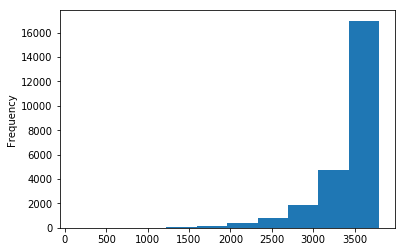

3799

In [13]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
pd.Series([max(seq) for seq in x_train_seq]).plot(kind='hist')
plt.show()
max( [max(seq) for seq in x_train_seq] )

In [14]:
#截長補短，讓所有影評所產生的數字序列長度一樣

In [15]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=380)

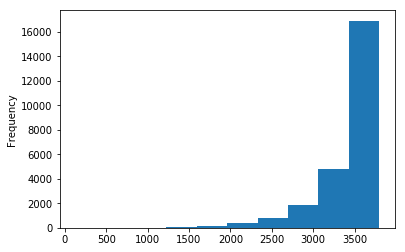

3799

In [16]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
pd.Series([max(seq) for seq in x_train]).plot(kind='hist')
plt.show()
max( [max(seq) for seq in x_train] )

# 加權權重


In [17]:
np.array(list(token.word_index.keys()))[:5] , np.array(list(token.word_index.values()))[:5]

(array(['the', 'and', 'a', 'of', 'to'], dtype='<U51'), array([1, 2, 3, 4, 5]))

In [18]:
vocab_size = 3800
embedding_matrix = np.zeros((vocab_size, 200))
embeddings_index = glove_embedded

for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    if i>=3799:
        break
    
embedding_matrix.shape

(3800, 200)

In [19]:
# 檢查
list(token.word_index.keys())[0], glove_embedded.get('the') == embedding_matrix[1]
list(token.word_index.keys())[3798], glove_embedded.get('disc') == embedding_matrix[-1]

('disc', array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True

# 建立模型

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional

In [21]:
model = Sequential()

In [22]:
##### input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
##### output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
##### input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [23]:
model.add(Embedding(input_dim=3800, 
                    output_dim=200,                    
                    input_length=380,
                    weights=[embedding_matrix]
                   ))
model.add(Dropout(0.2))

In [24]:
#model.add(LSTM(32))
model.add(Bidirectional(LSTM(32, activation='relu')))

In [25]:
model.add(Dense(units=256,
                activation='relu' ))
model.add(Dropout(0.2))

In [26]:
model.add(Dense(units=1,
                activation='sigmoid' ))

# 訓練模型

In [27]:
model.compile(loss='binary_crossentropy', 
              #optimizer='rmsprop', 
              optimizer='adam(lr=0.001)', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 200)          760000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 380, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                59648     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 836,545
Trainable params: 836,545
Non-trainable params: 0
_________________________________________________________________


In [28]:
train_history =model.fit(x_train, y_train,batch_size=100, 
                         epochs=10,verbose=1,
                         validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 344s 17ms/step - loss: 0.6138 - acc: 0.6605 - val_loss: 0.7922 - val_acc: 0.4798
Epoch 2/10
20000/20000 [==============================] - 343s 17ms/step - loss: 0.5272 - acc: 0.7336 - val_loss: 0.7700 - val_acc: 0.5362
Epoch 3/10
20000/20000 [==============================] - 342s 17ms/step - loss: 0.4767 - acc: 0.7650 - val_loss: 0.6976 - val_acc: 0.6122
Epoch 4/10
20000/20000 [==============================] - 344s 17ms/step - loss: 0.4431 - acc: 0.7859 - val_loss: 0.7720 - val_acc: 0.5868
Epoch 5/10
20000/20000 [==============================] - 344s 17ms/step - loss: 0.4121 - acc: 0.8048 - val_loss: 0.7841 - val_acc: 0.5966
Epoch 6/10
20000/20000 [==============================] - 356s 18ms/step - loss: 0.3873 - acc: 0.8206 - val_loss: 0.7916 - val_acc: 0.6204
Epoch 7/10
20000/20000 [==============================] - 347s 17ms/step - loss: 0.3662 - acc: 0.8326 - val_loss: 0.8

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

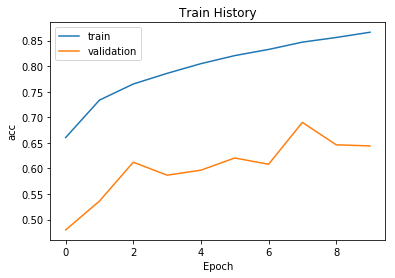

In [30]:
show_train_history(train_history,'acc','val_acc')

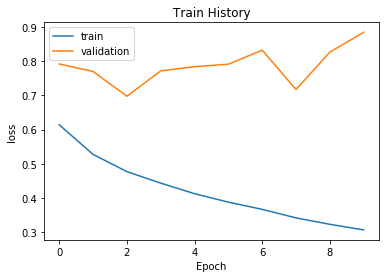

In [31]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [32]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]

25000/25000 [==============================] - 318s 13ms/step


0.75396

# 預測機率

probility=model.predict(x_test)

probility[:10]

for p in probility[12500:12510]:
    print(p)

# 預測結果

predict=model.predict_classes(x_test)

predict.shape

predict_classes=predict.reshape(25000)
predict_classes

# 查看預測結果

SentimentDict={1:'正面的',0:'負面的'}
def display_test_Sentiment(i):
    print(test_text[i])
    print('標籤label:',SentimentDict[y_test[i]],'預測結果:',SentimentDict[predict_classes[i]])

display_test_Sentiment(2)

display_test_Sentiment(3)

predict_classes[12500:12510]

display_test_Sentiment(12500)

#預測新的影評

input_text='''
Oh dear, oh dear, oh dear: where should I start folks. I had low expectations already because I hated each and every single trailer so far, but boy did Disney make a blunder here. I'm sure the film will still make a billion dollars - hey: if Transformers 11 can do it, why not Belle? - but this film kills every subtle beautiful little thing that had made the original special, and it does so already in the very early stages. It's like the dinosaur stampede scene in Jackson's King Kong: only with even worse CGI (and, well, kitchen devices instead of dinos).
The worst sin, though, is that everything (and I mean really EVERYTHING) looks fake. What's the point of making a live-action version of a beloved cartoon if you make every prop look like a prop? I know it's a fairy tale for kids, but even Belle's village looks like it had only recently been put there by a subpar production designer trying to copy the images from the cartoon. There is not a hint of authenticity here. Unlike in Jungle Book, where we got great looking CGI, this really is the by-the-numbers version and corporate filmmaking at its worst. Of course it's not really a "bad" film; those 200 million blockbusters rarely are (this isn't 'The Room' after all), but it's so infuriatingly generic and dull - and it didn't have to be. In the hands of a great director the potential for this film would have been huge.
Oh and one more thing: bad CGI wolves (who actually look even worse than the ones in Twilight) is one thing, and the kids probably won't care. But making one of the two lead characters - Beast - look equally bad is simply unforgivably stupid. No wonder Emma Watson seems to phone it in: she apparently had to act against an guy with a green-screen in the place where his face should have been. 
'''

input_seq = token.texts_to_sequences([input_text])

len(input_seq[0] )

pad_input_seq  = sequence.pad_sequences(input_seq , maxlen=380)

len(pad_input_seq[0])

predict_result=model.predict_classes(pad_input_seq)

predict_result

predict_result[0][0]

SentimentDict[predict_result[0][0]]

def predict_review(input_text):
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq  = sequence.pad_sequences(input_seq , maxlen=380)
    predict_result=model.predict_classes(pad_input_seq)
    print(SentimentDict[predict_result[0][0]])

#http://www.imdb.com/title/tt2771200/
#http://www.imdb.com/title/tt2771200

predict_review('''
It's hard to believe that the same talented director who made the influential cult action classic The Road Warrior had anything to do with this disaster.
Road Warrior was raw, gritty, violent and uncompromising, and this movie is the exact opposite. It's like Road Warrior for kids who need constant action in their movies.
This is the movie. The good guys get into a fight with the bad guys, outrun them, they break down in their vehicle and fix it. Rinse and repeat. The second half of the movie is the first half again just done faster.
The Road Warrior may have been a simple premise but it made you feel something, even with it's opening narration before any action was even shown. And the supporting characters were given just enough time for each of them to be likable or relatable.
In this movie there is absolutely nothing and no one to care about. We're supposed to care about the characters because... well we should. George Miller just wants us to, and in one of the most cringe worthy moments Charlize Theron's character breaks down while dramatic music plays to try desperately to make us care.
Tom Hardy is pathetic as Max. One of the dullest leading men I've seen in a long time. There's not one single moment throughout the entire movie where he comes anywhere near reaching the same level of charisma Mel Gibson did in the role. Gibson made more of an impression just eating a tin of dog food. I'm still confused as to what accent Hardy was even trying to do.
I was amazed that Max has now become a cartoon character as well. Gibson's Max was a semi-realistic tough guy who hurt, bled, and nearly died several times. Now he survives car crashes and tornadoes with ease?
In the previous movies, fuel and guns and bullets were rare. Not anymore. It doesn't even seem Post-Apocalyptic. There's no sense of desperation anymore and everything is too glossy looking. And the main villain's super model looking wives with their perfect skin are about as convincing as apocalyptic survivors as Hardy's Australian accent is. They're so boring and one-dimensional, George Miller could have combined them all into one character and you wouldn't miss anyone.
Some of the green screen is very obvious and fake looking, and the CGI sandstorm is laughably bad. It wouldn't look out of place in a Pixar movie.
There's no tension, no real struggle, or any real dirt and grit that Road Warrior had. Everything George Miller got right with that masterpiece he gets completely wrong here. 
''')

predict_review('''
Sure, I'm a huge film snob who (on the surface) only likes artsy-fartsy foreign films from before the 60's, but that hasn't stopped me from loving Disney's Beauty & The Beast; in fact, it's probably my favorite American animated film and is easily Disney's finest work. It's beautiful, it's breathtaking, it's warm, it's hilarious, it's captivating, and, in Disney fashion, it's magical. When I learned that Disney would be remaking their classic films, B&TB was undeniably the best wrapped package. How could they go wrong?
Oh man, they went wrong.
First thing's first: this film is so flat. The directing was dull and uninteresting throughout the entire film and it honestly felt like one of the Twilight sequels...and then I looked it up and found out that, yes, director Bill Condon was the man behind Breaking Dawn parts 1 & 2. Every shot looks bored and uninterested, which contrasts heavily with the original animated film that was constantly popping with vibrancy. The script too is boring because it's almost a complete remake of the original, though I guess most people won't mind that.
Next: the CGI is horrid. Although I didn't care for The Jungle Book from last year, I could at least admit that the CGI was breathtaking. The same cant be said for this film. Characters like Lumière, Cogsworth, Mrs Potts, and most of the cursed appliances have very strange, lifeless faces that are pretty off putting to be looking at for such a long time. All of the sets too look artificial and fake, especially the town towards the beginning. However, the biggest offender is easily and infuriatingly the character that mattered most: The Beast. The CGI on the Beast's face is so distracting that it completely takes you out of the film. His eyes are completely devoid of soul, and his mouth is a gaping video game black hole of fiction. Klaus Kinski looked much better in the Faerie Tale Theatre episode of Beauty & The Beast, and that was a 1984 TV show episode. But do you know why it looked better? Because it was an actual face with actual eyes, not some video game computerized synthetic monstrosity. When will studios learn that practical effects will always top CGI?
Finally: wasted casting. Emma Watson is beautiful, but she's no Belle. She is completely devoid of the warmth and humanity that made the animated Belle so beloved. Instead, she is cold and heartless throughout most of the film. Kevin Kline is 100% wasted and does nothing except look old. Ian McKellan, Ewan McGregor, Emma Thompson, and even Dan Stevens as the Beast are very expendable and could've been played by anyone else. The only good characters are Gaston and LeFou, mostly because they are fun and played by actors who breathe new life into their original shapes. If anything, this film should've been about Gaston and LeFou, but that would never happen because that would mean Disney couldn't cater to blind nostalgic 90's kids.
Overall, this film is a complete bore. It could've been better if even the special effects were good, but the CGI in particular is horrendous. I'm all for Disney remaking their nostalgia- catering 90's films, but they need to be interesting. This film, sadly, is not. Even the Christmas sequel is better than this film because it's at least something. 
''')

predict_review('''
I was really looking forward to this film. Not only has Disney recently made excellent live-action versions of their animated masterpieces (Jungle Book, Cinderella), but the cast alone (Emma Watson, Ian McKellen, Kevin Kline) already seemed to make this one a sure hit. Well, not so much as it turns out.
Some of the animation is fantastic, but because characters like Cogsworth (the clock), Lumière (the candelabra) and Chip (the little tea cup) now look "realistic", they lose a lot of their animated predecessors' charm and actually even look kind of creepy at times. And ironically - unlike in the animated original - in this new realistic version they only have very limited facial expressions (which is a creative decision I can't for the life of me understand).
Even when it works: there can be too much of a good thing. The film is overstuffed with lush production design and cgi (which is often weirdly artificial looking though) but sadly lacking in charm and genuine emotion. If this were a music album, I'd say it is "over-produced" and in need of more soul and swing. The great voice talent in some cases actually seems wasted, because it drowns in a sea of visual effects that numbs all senses. The most crucial thing that didn't work for me, though, is the Beast. He just never looks convincing. The eyes somehow don't look like real eyes and they're always slightly off.
On the positive side, I really liked Gaston, and the actor who played him, Luke Evans, actually gave the perhaps most energized performance of all. Kevin Kline as Belle's father has little to do but to look fatherly and old, but he makes the most of his part. Speaking of Belle, now that I've seen the film, I think her role was miscast. I think someone like Rachel McAdams would actually have been a more natural, lively and perhaps a bit more feisty Belle than Emma Watson.
If you love the original, you might want to give this one a pass, it's really not that good (although at least the songs were OK). Also, I'd think twice before bringing small children; without cute animated faces, all those "realistic" looking creatures and devices can be rather frightening for a child. ''')

predict_review('''
Up front: I'm probably not the right audience for this film. I only went because I was invited, and I wouldn't have gone to check this one out otherwise.
Firstly, some of the production values are really beautiful and reminded me of the animated classic in a good way. Also, the voice cast for the clock and the kitchen devices are great.
Secondly, the actors, well... this may sound kind of harsh, but I've never seen Emma Watson act so stiff in a movie. Her performance is wooden, which is pretty bad considering she's supposed to be the heart of the film. Also, she probably won't start a singing career anytime soon.
Thirdly (and most importantly), Beast. That's where they really dropped the ball. Giving him a lifeless CGI face was an unforgivable mistake, and it's such a constant distraction that I could never really get into the movie.
Overall, I'm afraid I wouldn't recommend this movie, at least not to adults. I'm sure most kids would enjoy it though, and it's not really a bad film: just a very mediocre one. 6 stars out of 10. 
''')

predict_review('''
Full disclosure, I didn't think the first movie was as bad as it was made out to be. It wasn't good in almost any sense, but it was to be expected given the combination of source material, resources and constraints.
That said, this sequel is 20x better than the first. Having established the characters in the first movie, the actors seem to be able to act now comfortably in their parts. The story becomes much more nuanced with plenty of dynamics on the go.
SPOILERS from now on
Can they maintain a "vanilla" relationship? Is he going to become controlling again and ruin things? Will she let it get out of control and ruin things also or stay on it? Who is that stalky girl and what happened to her exactly? what about his mother? and that ex of his? Will something occur with her infatuated boss?
On top of all of this, I realised while watching that the series was never about a bizarre sadist control freak, it's actually about all men and the story of a woman trying to find the balance between accepting or desiring the dominant behaviour of the male archetype and maintaining strength and independence in such a relationship.
While of course the fact that he is rich, while possibly relating to the power struggle, looks like it is going to be more and more used for generating further drama. The romance is much more evident in this movie to/ 
''')

# serialize model to JSON

model_json = model.to_json()
with open("SaveModel/Imdb_RNN_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("SaveModel/Imdb_RNN_model.h5")
print("Saved model to disk")